# Reconstruction of non-Cartesian data

This demonstration shows discusses the reconstruction of non-Cartesian data.

This demo is a 'script', i.e. intended to be run step by step in a
Python notebook such as Jupyter. It is organised in 'cells'. Jupyter displays these
cells nicely and allows you to run each cell on its own.

First version: 14th of June 2021  
Updated: 8th of May 2023  
Author: Christoph Kolbitsch  


CCP SyneRBI Synergistic Image Reconstruction Framework (SIRF).  
Copyright 2015 - 2021 Rutherford Appleton Laboratory STFC.  
Copyright 2015 - 2021 University College London.  
Copyright 2015 - 2023 Physikalisch-Technische Bundesanstalt.

This is software developed for the Collaborative Computational Project in Synergistic Reconstruction for Biomedical Imaging 
(http://www.ccpsynerbi.ac.uk/).

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Cartesian or non-Cartesian, that is the question

In the previous examples (e.g.`d_undersampled_reconstructions.ipynb`) we reconstructed data acquired on a Cartesian grid, i.e. each acquired k-space point has the same distance to its neighbours. This is not entirely true for undersampled data, because there we often have a fully sampled centre and an undersampled outer k-space with larger distances between neighbouring points. Nevertheless, we saw that we can simply fill the missing data with 0s and then everything is nicely equidistant again. 

One of the strenghts of __MRI__ is, that we can acquired our raw data (`AcquisitionData`) along (almost) arbitrary patterns. Nevertheless, in hospitals probably more than 99% of all scans are carried out using a Cartesian sampling scheme. Why?

Well the short and main answer is __FFT__ - the Fast Fourier Transform allows for really really really fast image reconstruction. As soon as our acquired k-space points are not on an equidistant grid, we cannot directly apply it but have to use a much slower approach leading to longer reconstruction times which nobody wants. But this is a great shame, because non-Cartesian k-space trajectories have lots of interesting properties which make them a really exciting field of research. 

## The answer of course is non-Cartesian

In the figure below you can see a comparison between Cartesian and radial undersampling of a transversal slice through the heart. On the far left you can see the fully sampled reference. Then next to that you can see the same image reconstructed from a 2x undersampled Cartesian k-space. Next to it the same but from a 2x undersampled radial k-space. In the row below you can see the same but not for an undersampling factor of 4.

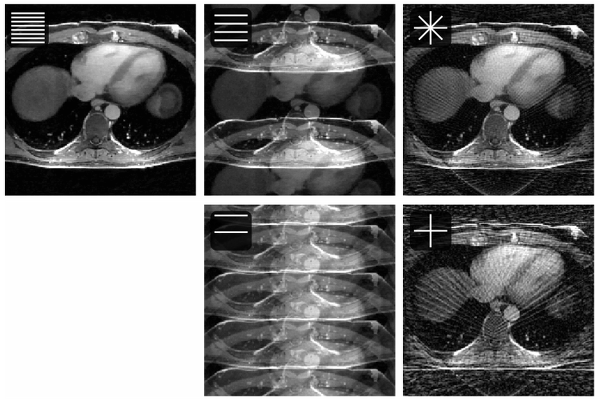

I hope you agree that for a given undersampling factor, radial sampling leads to a much better image quality. 

The term radial undersampling is a bit confusing, because as you can see from the small inserts in each image, when we talk about _radial undersampling_ we actually mean a radial sampling scheme with angular undersamling, i.e. we leave larger gaps along the angular direction.

There are lots and lots of different non-Cartesian MR sampling schemes: radial, spiral, koosh-ball, rosette, ring...

Now, that we are all convinced that non-Cartesian k-space sampling is great, let's start!

In [ ]:
# Make sure figures appears inline and animations works
%matplotlib widget

# Setup the working directory for the notebook
import sys
sys.path.append('SIRF-Exercises/notebooks/MR')
import notebook_setup
from sirf_exercises import cd_to_working_dir
cd_to_working_dir('MR', 'g_non_cartesian_reconstruction')

In [ ]:
__version__ = '0.1.0'

# import engine module
import sirf.Gadgetron as pMR
from sirf_exercises import exercises_data_path

# import CIL functionality for visualisation and iterative reconstruction
from cil.utilities.jupyter import islicer
from cil.optimisation.algorithms import FISTA, PDHG
from cil.optimisation.functions import LeastSquares, ZeroFunction, L2NormSquared
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# import further modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [ ]:
# Define a function which plots 3D volume(s) in two orthogonal views
def plot_rpe_3d(dat, sl_idx, lbl):
    fig, ax = plt.subplots(2,len(dat), squeeze=False)
    for ind in range(len(dat)):
        ax[0,ind].imshow(np.rot90(np.abs(dat[ind][:, sl_idx[0], :]), 1), cmap='inferno')
        ax[0,ind].set_xticks([])
        ax[0,ind].set_yticks([])
        ax[0,ind].set_ylabel('Foot-Head')
        ax[0,ind].set_xlabel('Right-Left')
        ax[0,ind].set_title(lbl[ind])
        
        ax[1,ind].imshow(np.rot90(np.abs(dat[ind][:, :, sl_idx[1]])), cmap='inferno')
        ax[1,ind].set_xticks([])
        ax[1,ind].set_yticks([])
        ax[1,ind].set_ylabel('Anterior-Posterior')
        ax[1,ind].set_xlabel('Right-Left')
        

The data we are going to use was acquired with a _Golden Radial Phase Encoding (GRPE) scheme_. This is a 3D MR sampling scheme which combines Cartesian frequency encoding (readout, $k_x$) with non-Cartesian phase encoding ($k_y$ - $k_z$). This means we have one direction which is fully sampled ($k_x$) and the other two directions ($k_y$ - $k_z$) which can be undersampled to speed up data acquisition. If you want to find out more about this trajectory please refer to the following paper:

Boubertakh R et al. 2009 Whole-heart imaging using undersampled radial phase encoding (RPE) and iterative sensitivity encoding (SENSE) reconstruction. Magn. Reson. Med. 62, 1331–1337. (doi:10.1002/mrm.22102)

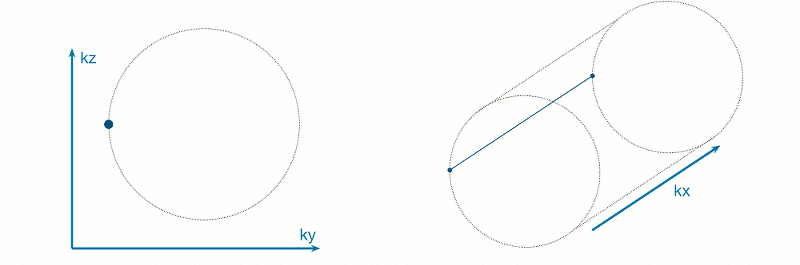

In [ ]:
%%bash 
# Run this script to make sure the data is downloaded.
#bash ../../scripts/download_data.sh -m

In [ ]:
# Load in the data
data_path = exercises_data_path('MR')
filename = os.path.join(data_path, '3D_GRPE_no_motion.h5')
acq_data = pMR.AcquisitionData(filename)
acq_data.sort_by_time()

# Here we are cheating a little bit for the moment, because we have pre-processed the file already. 
# If we had not done that and would like to load a raw data file directly from the scanner, we would
# have to do:
# acq_data = pMR.AcquisitionData(filename)
# acq_data = pMR.preprocess_acquisition_data(acq_data)
# acq_data = pMR.set_grpe_trajectory(acq_data)

Especially the last line is important: `acq_data = pMR.set_grpe_trajectory(acq_data)`

Here we calculate the trajectory, i.e. based on the parameters provided by the scanner (the header information of the raw data file) we calculate the ($k_x$, $k_y$, $k_z$) position of each acquired k-space point. So let's have a look what this looks like. As mentioned above _GRPE_ combines non-Cartesian phase encoding with Cartesian frequency encoding, therefore, we only have to look at the k-space locations of the phase encoding points.

In [ ]:
ktraj = pMR.get_data_trajectory(acq_data)

If we look at the dimension of the k-space trajectory `ktra`

In [ ]:
print(ktraj.shape)

and compare it to the k-space data

In [ ]:
print(acq_data.dimensions())

We can see that we have got a pair of ($k_y$, $k_z$) entries in `ktraj`for each phase encoding point (first dimension in `acq_data`). Because we paid attention when we acquired our MR data, we remember that we obtained 144 phase encoding points along each RPE line. So let's plot the data acquisition over time:

In [ ]:
# Visualise trajectory
import matplotlib.animation

fig, ax = plt.subplots(figsize=(5,5))
l, = ax.plot([],[], '.b')
ax.axis([-0.6, 0.6, -0.6, 0.6])


def animate(num_rpe_lines):
    l.set_data(ktraj[:(num_rpe_lines+1)*144,0], 
               ktraj[:(num_rpe_lines+1)*144,1])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=ktraj.shape[0]//144)  

We have a fully data acquisition with 144 points along the radial direction of _GRPE_ and undersampling along the angular direction of _GRPE_ because we only have 40 GRPE lines. If we assume that for a fully sampled k-space, we would need 144 _GRPE_ lines we can calculate the undersampling factor as $\frac{144}{40}$ = $3.6$. (Technically our undersampling factor is higher, because we would need $144 * \frac{\pi}{2}$ to full fill the Nyquist sampling theorem everywhere in k-space, but this is a small detail). 

## Image reconstruction
As a first step we calculate the coil sensitivity maps again. We always need them in MRI...

In [ ]:
csm = pMR.CoilSensitivityData()
csm.smoothness = 100
csm.calculate(acq_data)

Because we have got a 3D volume which we imaged, our coil maps are 4D (3D + coil dimension), so we will use some fance __CIL__ tools to visualise them:

In [ ]:
# Let's get the coil maps as a numpy array 
vis_dat = np.abs(csm.as_array())

# Let's select a central slice
vis_dat = vis_dat[:,:,64,:]

# Visualise!
islicer(vis_dat, direction=0)

In [ ]:
# Create acquisition model
E = pMR.AcquisitionModel(acqs=acq_data, imgs=csm)
E.set_coil_sensitivity_maps(csm)

Let's take a second to discuss what the `AcquisitionModel` for a non-Cartesian sampling scheme looks like. We remember from previous notebooks (`d_undersampled_reconstructions.ipynb`) that `forward` was defined as:
$$
E x = y_c = \mathcal{F}( C_c \cdot x).
$$
describing how the k-space data ($y_c$) for a single coil $c$ is obtained from the image $x$. The `backward` operation was defined as:
$$
E^H y = x = \sum_c C_c^*\mathcal{F}^{-1}(y) 
$$
and we have used `forward` and `backward` for iterative image reconstruction. 

In addition to `forward` and `backward`, the `AcquisitionModel` has also got the function: `inverse`. For a standard Cartesian sampling scheme, `backward` and `inverse` are identical. For non-Cartesian sampling schemes, this is not the case anymore. `backward` is defined to be the hermitian conjugate of `forward`, where as `inverse` obtains an image by also taking the density of the k-space samples into account. Now, what does that mean?!

If we think of a Cartesian sampling scheme, where all the data points are on a rectilinear grid, then the density of k-space points is the same everywhere. In our case, where we have radial lines, all these lines intersect in the centre, and hence there is much higher density of acquired k-space points there, than in the outer parts of k-space. If we don't take this into consideration, then the central k-space frequencies get weighted higher (simply because there are more of those) in the reconstructed image. To compensate for this, we can apply a so-called _density compensation function_ to the k-space, prior to applying $E^H$. This is all, that the `inverse` does - weight $y$ and then reconstruct an image $x$. Something similar happens in CT, where we can do a _filtered back projection_ where we also compensate for the fact, that more data points have been acquired in the centre of the FOV compared to the peripherie. 

So let's call `inverse` and `backward` and compare the results:

In [ ]:
# Inverse
rec_im_inv = E.inverse(acq_data)
rec_im_inv_arr = rec_im_inv.as_array()

# Backward
rec_im_bck = E.backward(acq_data)
rec_im_bck_arr = rec_im_bck.as_array()

In [ ]:
# Compare Backward and Inverse
plot_rpe_3d([rec_im_bck_arr, rec_im_inv_arr], [64, 64], ['Backward', 'Inverse'])

## Didn't we forget anything?
We mentioned above that we cannot directly apply _FFT_ to non-Cartesian data but it is more complex. Have we taken this into consideration already?

Yes, we have! Well, actually __SIRF__ has. The raw data coming from the scanner includes information about the trajectory which was used for data acquisition. Based on this information, __SIRF__ calculated the trajectory and then also applied to correct `AcquisitionModel` to the data. So far, __SIRF__ can reconstruction _Cartesian_ and _GRPE_ but _2D radial_ and _2D spiral_ will follow soon.

To reconstruct the non-Cartesian data we could of course use the _discrete Fourier transform (DFT)_ because this works for any discrete data points but this would be really slow. Therefore, in our code we use the _Non-uniform fast Fourier transform (NUFFT)_ which tries to leverage the speed-up achieved with _FFT_ also for non-uniform data. If you are interested in the details, here is a link to an implementation which is widely used: 

https://math.nyu.edu/~greengar/glee_nufft_sirev.pdf

## Iterative reconstruction
Considering that we have an undersampling factor of 4, our images from `inverse` look quite good, but of course we can do better. So we are going to use an iterative reconstruction. We could use the conjugate gradient approach discussed in the notebook `d_undersampled_reconstructions.ipynb`, but we want to do something fancier.

So we are going to use _FISTA_ from __CIL__. 

In [ ]:
# We set up our AcquisitionModel
E = pMR.AcquisitionModel(acqs=acq_data, imgs=rec_im_inv)
E.set_coil_sensitivity_maps(csm)

# Use the result of the inverse as our starting point
x_init = rec_im_inv.clone()

# Define our objective/loss function as least squares between Ex and y
f = LeastSquares(E, acq_data, c=1)

# Here we are not going to use any further regularisation, but if you want to change this, 
# using e.g. TV-regularisation you could change this to
# alpha = 0.00001
# G = alpha * FGP_TV(max_iteration=10, device='cpu')
# where alpha is the strenght of the regularisation
G = ZeroFunction()


# Set up FISTA
fista = FISTA(initial=x_init.fill(0.0), f=f, g=G)
fista.max_iteration = 100
fista.update_objective_interval = 5


# Run FISTA for least squares
fista.run(40, verbose=True)

In [ ]:
# Compare result of FISTA to Inverse and Backward
rec_fista_arr = fista.get_output().as_array()

plot_rpe_3d([rec_im_bck_arr, rec_im_inv_arr, rec_fista_arr], [64, 64], ['Backward', 'Inverse', 'FISTA'])

In [ ]:
f = L2NormSquared(b=acq_data)
pdhg = PDHG(f = f, g = G, operator = E, 
            max_iteration = 100,
            update_objective_interval = 1, initial=x_init.fill(0.0))

pdhg.run(10, verbose=True)


In [ ]:
# Compare result of PDHG to Inverse, Backward and FISTA
rec_pdhg_arr = pdhg.get_output().as_array()

plot_rpe_3d([rec_im_bck_arr, rec_im_inv_arr, rec_fista_arr, rec_pdhg_arr], [64, 64], ['Backward', 'Inverse', 'FISTA', 'PDHG'])